## 0. Setup

In [1]:
import numpy as np
import pandas as pd
import csv
import os
import re

from copy import deepcopy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pd.options.display.max_columns = 999

In [4]:
# # current directory
# current_dir = os.getcwd()

# # two folders up
# parent_dir = os.path.dirname(os.path.dirname(current_dir))

# # data directory
# data_dir = os.path.join(parent_dir, "data/mimic-iv")
# data_dir_processed = os.path.join(parent_dir, "data/processed")

# data directory (GDrive)
data_dir = '/content/drive/MyDrive/DATASCI_210/data/mimic-iv/'
data_dir_processed = '/content/drive/MyDrive/DATASCI_210/data/processed/'

## 1. Functions

In [5]:
class TextToColumns:
    """
    A class to extract specific sections from a given text and convert them into separate columns in a DataFrame.

    Attributes:
        selected_sections (list): A list of section headers to be extracted from the text.
    """

    selected_sections = [
        "Service:",
        "Allergies:",
        "Attending:",
        "Chief Complaint:",
        "Major Surgical or Invasive Procedure:",
        "History of Present Illness:",
        "Past Medical History:",
        "Social History:",
        "Family History:",
        "Physical Exam:",
        "Brief Hospital Course:",
        "Medications on Admission:",
        "Discharge Medications:",
    ]

    @staticmethod
    def format_text_column_names(unformatted_columns_list):
        """
        Formats section headers into column names by replacing spaces with underscores and removing colons.

        Args:
            unformatted_columns_list (list): The list of section headers to format.

        Returns:
            list: A list of formatted column names.
        """
        return [col.replace(" ", "_").replace(":", "").lower() for col in unformatted_columns_list]

    @staticmethod
    def remove_duplicated_title(text, title):
        """
        Removes a duplicated title from the text, if present.

        Args:
            text (str): The text from which to remove the duplicated title.
            title (str): The title to remove from the text.

        Returns:
            str: The text with the duplicated title removed.
        """
        title_pattern = re.escape(title.strip().lower()) + r"\s*:\s*\n"
        return re.sub(title_pattern, '', text, count=1, flags=re.IGNORECASE)

    def extract_section_text(self, text, start_pattern, next_col_patterns):
        """
        Extracts the text for a specific section from the overall text.

        Args:
            text (str): The overall text from which to extract the section.
            start_pattern (str): The starting pattern that identifies the beginning of the section.
            next_col_patterns (list): Patterns for identifying the start of subsequent sections.

        Returns:
            str: The extracted text for the specified section.
        """
        # Find the start index of the section
        start_index = text.find("\n" + start_pattern)
        if start_index == -1:
            return ""

        # Adjust the start index to skip the section header
        adjusted_start_index = start_index + len(start_pattern) + 1

        # Find the index of the start of the next section to determine the end of the current section
        next_section_index = min([text.find("\n" + np) for np in next_col_patterns if text.find("\n" + np) != -1] + [len(text)])

        # Extract the section text and remove any duplicated title
        section_text = text[adjusted_start_index:next_section_index].strip()
        section_text = self.remove_duplicated_title(section_text, start_pattern)

        return section_text

    def explode_text_into_columns(self, text_to_explode):
        """
        Converts selected sections from the provided text into separate columns in a DataFrame.

        Args:
            text_to_explode (str): The text to process and extract sections from.

        Returns:
            pd.DataFrame: A DataFrame where each column represents a specific section from the text.
        """
        # Format the section headers into DataFrame column names
        formatted_column_names = self.format_text_column_names(self.selected_sections)
        exploded_data = {col: "" for col in formatted_column_names}

        # Extract text for each section and add to the exploded_data dictionary
        for i, col in enumerate(self.selected_sections):
            next_cols = self.selected_sections[i+1:]  # Determine the headers for subsequent sections
            section_text = self.extract_section_text(text_to_explode, col, next_cols)
            formatted_col_name = col.replace(" ", "_").replace(":", "").lower()
            exploded_data[formatted_col_name] = section_text

        # Create and return a DataFrame with the exploded data
        return pd.DataFrame([exploded_data], columns=formatted_column_names)

In [6]:
class ProcessText:

    @staticmethod
    def find_paragraph_start(section_text):
        match = re.search(r'history of present illness:', section_text.lower())
        return match.end() if match else 0

    @staticmethod
    def find_paragraph_end(section_text):
        match = re.search(r'(\n\.|\nin the ed)', section_text.lower())
        return match.start() if match else None

    def process_history_of_present_illness(self, text_to_process):
        section_text = text_to_process
        start_paragraph_index = self.find_paragraph_start(section_text)
        end_paragraph_index = self.find_paragraph_end(section_text)
        if end_paragraph_index:
            section_text = text_to_process[start_paragraph_index:end_paragraph_index].strip()
        else:
            section_text = text_to_process[start_paragraph_index:].strip()
        return section_text

In [7]:
def total_word_count(x):
  word_list = str(x).split()
  return len(word_list)

def filtered_word_count(x):
  word_list = str(x).split()
  filtered_list = []
  for element in word_list:
    if "___" not in element:
      filtered_list.append(element)
  return len(filtered_list)

def find_group(value):
    """
    Find the group for the given value.

    Parameters:
    - value: An integer representing a value.

    Returns:
    - A string representing the group the value belongs to.
    """
    if value < 0:
        return "Invalid value. Must be non-negative."

    # Adjust the calculation for the lower bound
    lower_bound = ((value - 1) // 10) * 10 + 1

    # Calculate the upper bound based on the new lower bound
    upper_bound = lower_bound + 9

    return f"{lower_bound}-{upper_bound}"

def convert_to_int_or_replace(data):
    """
    Convert values in the given series to integers when possible.
    Replace values that cannot be converted to integers with 999.

    Parameters:
    - data: A pandas Series with values to convert.

    Returns:
    - A pandas Series with all values converted to integers.
    """
    def try_convert(x):
        try:
            return int(x)
        except ValueError:
            return 999

    return data.apply(try_convert)

In [8]:
def return_column_values_count_and_percentage(dataframe_input, column_input):
    counts = dataframe_input[column_input].value_counts()
    percentages = dataframe_input[column_input].value_counts(normalize=True)
    counts_percentages = pd.concat([counts,percentages], axis=1, keys=['count', 'percentage'])
    counts_percentages["cumsum"] = counts_percentages["percentage"].cumsum().mul(100).round(1).astype(str) + '%'
    counts_percentages["count"] = counts_percentages.apply(lambda x: "{:,}".format(x["count"]), axis=1)
    counts_percentages["percentage"] = counts_percentages["percentage"].mul(100).round(1).astype(str) + '%'
    return counts_percentages

In [9]:
def return_column_values_sum_and_percentage(dataframe_input, column_input):
    total_sum = dataframe_input[column_input].sum()
    percentages = dataframe_input[column_input] / total_sum
    sums_percentages = pd.DataFrame({
        'sum': dataframe_input[column_input],
        'percentage': percentages
    })
    sums_percentages['cumsum_percentage'] = sums_percentages['percentage'].cumsum()
    sums_percentages['sum'] = sums_percentages['sum'].apply(lambda x: "{:,}".format(x))
    sums_percentages['percentage'] = sums_percentages['percentage'].mul(100).round(1).astype(str) + '%'
    sums_percentages['cumsum_percentage'] = sums_percentages['cumsum_percentage'].mul(100).round(1).astype(str) + '%'
    return sums_percentages

## 2. Data Acquisition

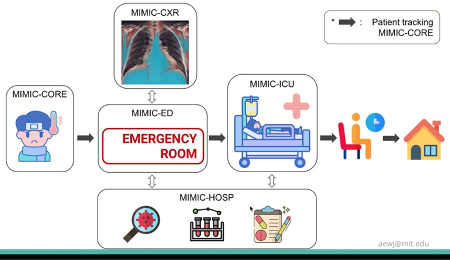

### 2.1. ED

In [10]:
# Define the path to the CSV file
ed_folder_path = os.path.join(data_dir, "ed/")

# Define the names of the CSV files
ed_triage_filename = 'triage.csv'

# Load the CSV files into a DataFrame
ed_triage = pd.read_csv(ed_folder_path + ed_triage_filename).add_prefix('ed_')

### 2.3. Hosp

In [11]:
# Define the path to the CSV file
hosp_folder_path = os.path.join(data_dir, "hosp/")

# Define the names of the CSV files
hosp_transfers_filename = 'transfers.csv'

# Load the CSV files into a DataFrame
hosp_transfers = pd.read_csv(hosp_folder_path + hosp_transfers_filename).add_prefix('hosp_')

### 2.4. CXR

In [12]:
# Define the path to the CSV file
cxr_folder_path = os.path.join(data_dir, "cxr/")

# Define the names of the CSV files
cxr_study_filename = 'study.csv'

# Load the CSV files into a DataFrame
cxr_study = pd.read_csv(cxr_folder_path + cxr_study_filename).add_prefix('cxr_')

### 2.5. CXR-JPG

In [13]:
# Define the path to the CSV file
cxr_jpg_folder_path = os.path.join(data_dir, "cxr_jpg/")

# Define the names of the CSV files
cxr_chexpert_filename = 'mimic-cxr-2.0.0-chexpert.csv'

# Load the CSV files into a DataFrame
cxr_chexpert = pd.read_csv(cxr_jpg_folder_path + cxr_chexpert_filename).add_prefix('cxr_')

### 2.6. Note

In [14]:
# Define the path to the CSV file
note_folder_path = os.path.join(data_dir, "note/")

# Define the names of the CSV files
note_discharge_filename = 'discharge.csv'
note_radiology_filename = 'radiology.csv'

# Load the CSV files into a DataFrame
note_discharge = pd.read_csv(note_folder_path + note_discharge_filename).add_prefix('note_')
note_radiology = pd.read_csv(note_folder_path + note_radiology_filename).add_prefix('note_')

## 3. Data Preprocessing

### 3.1. `hosp_transfers`

In [15]:
hosp_transfers.head()

,hosp_subject_id,hosp_hadm_id,hosp_transfer_id,hosp_eventtype,hosp_careunit,hosp_intime,hosp_outtime
0,10000032,22595853.0,33258284,ED,Emergency Department,2180-05-06 19:17:00,2180-05-06 23:30:00
1,10000032,22595853.0,35223874,admit,Transplant,2180-05-06 23:30:00,2180-05-07 17:21:27
2,10000032,22595853.0,36904543,discharge,NaN,2180-05-07 17:21:27,NaN
3,10000032,22841357.0,34100253,discharge,NaN,2180-06-27 18:49:12,NaN
4,10000032,22841357.0,34703856,admit,Transplant,2180-06-26 21:31:00,2180-06-27 18:49:12


In [16]:
# Create a deep copy of the hosp_transfers DataFrame to avoid modifying the original data
transfers_processed = deepcopy(hosp_transfers)

# Sort the data by patient ID and admission time in ascending order for chronological analysis
transfers_processed = transfers_processed.sort_values(["hosp_subject_id", "hosp_intime"], ascending=[True, True])

# Merge care unit data, using the event type capitalized if care unit is missing
transfers_processed.loc[:, "hosp_careunit_merged"] = transfers_processed.apply(
    lambda row: row["hosp_careunit"] if pd.isna(row["hosp_careunit"]) == False else row["hosp_eventtype"].capitalize(),
    axis=1
)

# Merge transfer and admission IDs, prioritizing admission ID where available
transfers_processed.loc[:, "hosp_visit_id_merged"] = transfers_processed.apply(
    lambda row: row["hosp_transfer_id"] if pd.isna(row["hosp_hadm_id"]) else row["hosp_hadm_id"],
    axis=1
)

# Ensure the merged visit ID is in integer format for consistency
transfers_processed.loc[:, "hosp_visit_id_merged"] = transfers_processed["hosp_visit_id_merged"].astype(int)

# Convert admission and discharge times to datetime format for time-based operations
transfers_processed['hosp_in_datetime'] = pd.to_datetime(transfers_processed['hosp_intime'])
transfers_processed['hosp_out_datetime'] = pd.to_datetime(transfers_processed['hosp_outtime'])

# Assign a sequence number to each transfer for each visit, starting from 1
transfers_processed.loc[:, "hosp_sequence"] = transfers_processed.groupby(["hosp_visit_id_merged", "hosp_subject_id"]).cumcount() + 1

# Determine the maximum sequence number for each visit to indicate total transfers
transfers_processed.loc[:, "hosp_sequence_max"] = transfers_processed.groupby(["hosp_visit_id_merged", "hosp_subject_id"])["hosp_sequence"].transform('max')

# Aggregate care unit flow, and calculate the earliest admission and latest discharge times for each visit
hosp_transfer_dates_by_visit = transfers_processed.groupby(["hosp_visit_id_merged", "hosp_subject_id"]).agg(
    {"hosp_careunit_merged": lambda x: ', '.join(x), "hosp_in_datetime": "min", "hosp_out_datetime": "max"}
    ).reset_index().rename(columns={"hosp_careunit_merged": "hosp_careunit_flow", "hosp_in_datetime": "hosp_min_datetime", "hosp_out_datetime": "hosp_max_datetime"})

# Merge the aggregated visit data back into the main DataFrame for enriched analysis
transfers_processed = pd.merge(transfers_processed, hosp_transfer_dates_by_visit, how="left", on=["hosp_visit_id_merged", "hosp_subject_id"])

<ipython-input-16-04bc292297bb>:20: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  transfers_processed.loc[:, "hosp_visit_id_merged"] = transfers_processed["hosp_visit_id_merged"].astype(int)


In [17]:
transfers_processed.head()

,hosp_subject_id,hosp_hadm_id,hosp_transfer_id,hosp_eventtype,hosp_careunit,hosp_intime,hosp_outtime,hosp_careunit_merged,hosp_visit_id_merged,hosp_in_datetime,hosp_out_datetime,hosp_sequence,hosp_sequence_max,hosp_careunit_flow,hosp_min_datetime,hosp_max_datetime
0,10000032,22595853.0,33258284,ED,Emergency Department,2180-05-06 19:17:00,2180-05-06 23:30:00,Emergency Department,22595853,2180-05-06 19:17:00,2180-05-06 23:30:00,1,3,"Emergency Department, Transplant, Discharge",2180-05-06 19:17:00,2180-05-07 17:21:27
1,10000032,22595853.0,35223874,admit,Transplant,2180-05-06 23:30:00,2180-05-07 17:21:27,Transplant,22595853,2180-05-06 23:30:00,2180-05-07 17:21:27,2,3,"Emergency Department, Transplant, Discharge",2180-05-06 19:17:00,2180-05-07 17:21:27
2,10000032,22595853.0,36904543,discharge,NaN,2180-05-07 17:21:27,NaN,Discharge,22595853,2180-05-07 17:21:27,NaT,3,3,"Emergency Department, Transplant, Discharge",2180-05-06 19:17:00,2180-05-07 17:21:27
3,10000032,22841357.0,38112554,ED,Emergency Department,2180-06-26 15:54:00,2180-06-26 21:31:00,Emergency Department,22841357,2180-06-26 15:54:00,2180-06-26 21:31:00,1,3,"Emergency Department, Transplant, Discharge",2180-06-26 15:54:00,2180-06-27 18:49:12
4,10000032,22841357.0,34703856,admit,Transplant,2180-06-26 21:31:00,2180-06-27 18:49:12,Transplant,22841357,2180-06-26 21:31:00,2180-06-27 18:49:12,2,3,"Emergency Department, Transplant, Discharge",2180-06-26 15:54:00,2180-06-27 18:49:12


In [18]:
# There's no data loss
print(f"hosp_transfers")
print("="*25)
print(f"Shape: {hosp_transfers.shape}")
print(f"Total Unique Patient IDs: {hosp_transfers.hosp_subject_id.nunique():,}")
print(f"Total Unique Admission IDs: {hosp_transfers.hosp_hadm_id.nunique():,}")
print(f"Total Unique Transfer IDs: {hosp_transfers.hosp_transfer_id.nunique():,}")

print("\n")

print(f"transfers_processed")
print("="*25)
print(f"Shape: {transfers_processed.shape}")
print(f"Total Unique Patient IDs: {transfers_processed.hosp_subject_id.nunique():,}")
print(f"Total Unique Admission IDs: {transfers_processed.hosp_hadm_id.nunique():,}")
print(f"Total Unique Visit IDs: {transfers_processed.hosp_visit_id_merged.nunique():,}")

hosp_transfers
Shape: (1890972, 7)
Total Unique Patient IDs: 299,712
Total Unique Admission IDs: 431,231
Total Unique Transfer IDs: 1,890,972


transfers_processed
Shape: (1890972, 16)
Total Unique Patient IDs: 299,712
Total Unique Admission IDs: 431,231
Total Unique Visit IDs: 761,254


### 3.2. `cxr_jpg`

In [19]:
cxr_chexpert.head()

,cxr_subject_id,cxr_study_id,cxr_Atelectasis,cxr_Cardiomegaly,cxr_Consolidation,cxr_Edema,cxr_Enlarged Cardiomediastinum,cxr_Fracture,cxr_Lung Lesion,cxr_Lung Opacity,cxr_No Finding,cxr_Pleural Effusion,cxr_Pleural Other,cxr_Pneumonia,cxr_Pneumothorax,cxr_Support Devices
0,10000032,50414267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,10000032,53189527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,10000032,53911762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,10000032,56699142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,10000764,57375967,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN


In [20]:
identifiers = [
    'cxr_subject_id',
    'cxr_study_id',
]

findings_dict = {
    'cxr_Atelectasis': 'atelectasis',
    'cxr_Cardiomegaly': 'cardiomegaly',
    'cxr_Consolidation': 'consolidation',
    'cxr_Edema': 'edema',
    'cxr_Enlarged Cardiomediastinum': 'enlarged_cardiomediastinum',
    'cxr_Fracture': 'fracture',
    'cxr_Lung Lesion': 'lung_lesion',
    'cxr_Lung Opacity': 'lung_opacity',
    'cxr_No Finding': 'no_finding',
    'cxr_Pleural Effusion': 'pleural_effusion',
    'cxr_Pleural Other': 'pleural_other',
    'cxr_Pneumonia': 'pneumonia',
    'cxr_Pneumothorax': 'pneumothorax',
    'cxr_Support Devices': 'support_devices', # That's not a pathology
}

# Create a deep copy of the cxr_chexpert DataFrame to avoid modifying the original data
cxr_chexpert_processed = deepcopy(cxr_chexpert)
# Rename columns in the dataset based on the 'pathologies' dictionary for consistency
cxr_chexpert_processed.rename(columns=findings_dict, inplace=True)
# Select only the columns specified by 'identifiers' and the renamed pathology columns
cxr_chexpert_processed = cxr_chexpert_processed[identifiers + list(findings_dict.values())]
# Convert pathology labels to a standardized format: 1 for positive, 0 for negative, 0 for uncertain or missing
for col in list(findings_dict.values()):
    cxr_chexpert_processed[col] = cxr_chexpert_processed[col].apply(lambda x: 1 if x == 1.0 else 0)
# Count the total number of positive labels for each record
cxr_chexpert_processed["positive_label_total"] = cxr_chexpert_processed[list(findings_dict.values())].apply(lambda row: (row.values == 1).sum(), axis=1)
# Create a column listing the findings identified as positive for each record, separated by commas
cxr_chexpert_processed["finding_names"] = cxr_chexpert_processed.apply(
    lambda row: ', '.join([col for col in list(findings_dict.values()) if row[col] == 1.0]) if any(row[list(findings_dict.values())] == 1.0) else np.nan, axis=1)

In [21]:
cxr_chexpert_processed.head()

,cxr_subject_id,cxr_study_id,atelectasis,cardiomegaly,consolidation,edema,enlarged_cardiomediastinum,fracture,lung_lesion,lung_opacity,no_finding,pleural_effusion,pleural_other,pneumonia,pneumothorax,support_devices,positive_label_total,finding_names
0,10000032,50414267,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,no_finding
1,10000032,53189527,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,no_finding
2,10000032,53911762,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,no_finding
3,10000032,56699142,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,no_finding
4,10000764,57375967,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,consolidation


In [22]:
# Number of studies by total number of labels in xray (CheXpert)
return_column_values_sum_and_percentage(cxr_chexpert_processed.groupby(["positive_label_total"]).agg({"cxr_study_id": "count"}), "cxr_study_id")

,sum,percentage,cumsum_percentage
positive_label_total,,,
0,"10,884",4.8%,4.8%
1,"107,186",47.0%,51.8%
2,"52,183",22.9%,74.7%
3,"30,381",13.3%,88.1%
4,"18,047",7.9%,96.0%
5,"7,056",3.1%,99.1%
6,"1,766",0.8%,99.9%
7,288,0.1%,100.0%
8,34,0.0%,100.0%


In [23]:
# Number of studies by pathology of xrays with a single label (CheXpert)
return_column_values_sum_and_percentage(cxr_chexpert_processed[cxr_chexpert_processed.positive_label_total == 1].groupby(["finding_names"]).agg({"cxr_study_id": "count"}).sort_values("cxr_study_id", ascending=False), "cxr_study_id")

,sum,percentage,cumsum_percentage
finding_names,,,
no_finding,"65,282",60.9%,60.9%
lung_opacity,"9,605",9.0%,69.9%
cardiomegaly,"7,358",6.9%,76.7%
atelectasis,"5,253",4.9%,81.6%
pleural_effusion,"4,720",4.4%,86.0%
pneumonia,"3,045",2.8%,88.9%
edema,"2,883",2.7%,91.6%
support_devices,"2,781",2.6%,94.2%
pneumothorax,"1,652",1.5%,95.7%


In [26]:
findings_list = [
    'atelectasis',
    'cardiomegaly',
    'consolidation',
    'edema',
    'enlarged_cardiomediastinum',
    'fracture',
    'lung_lesion',
    'lung_opacity',
    'no_finding',
    'pleural_effusion',
    'pleural_other',
    'pneumonia',
    'pneumothorax',
    'support_devices',
]

identifiers_columns = [
    'cxr_subject_id',
    'cxr_study_id',
]

additional_columns = [
    'positive_label_total',
    'finding_names',
]

# # Filter dataset to only include observations with a single finding
# cxr_chexpert_processed_filtered = cxr_chexpert_processed[cxr_chexpert_processed.positive_label_total == 1]
# Select only the columns that correspond to the findings
cxr_chexpert_processed_filtered = cxr_chexpert_processed[identifiers_columns + findings_list + additional_columns].reset_index(drop=True)

In [27]:
print(f"CheXpert")
print("-"*50)
print(f"cxr_chexpert_processed")
print("="*25)
print(f"Shape: {cxr_chexpert_processed.shape}")
print(f"Total Unique Patient IDs: {cxr_chexpert_processed.cxr_subject_id.nunique():,}")
print(f"Total Unique Study IDs: {cxr_chexpert_processed.cxr_study_id.nunique():,}")
print(f"Total Unique Combination of findings: {cxr_chexpert_processed.finding_names.nunique():,}")
print("-"*10)
print(f"cxr_chexpert_processed_filtered")
print("="*25)
print(f"Shape: {cxr_chexpert_processed_filtered.shape}")
print(f"Total Unique Patient IDs: {cxr_chexpert_processed_filtered.cxr_subject_id.nunique():,}")
print(f"Total Unique Study IDs: {cxr_chexpert_processed_filtered.cxr_study_id.nunique():,}")
print(f"Total Unique Combination of findings: {cxr_chexpert_processed_filtered.finding_names.nunique():,}")

CheXpert
--------------------------------------------------
cxr_chexpert_processed
Shape: (227827, 18)
Total Unique Patient IDs: 65,379
Total Unique Study IDs: 227,827
Total Unique Combination of findings: 1,726
----------
cxr_chexpert_processed_filtered
Shape: (227827, 18)
Total Unique Patient IDs: 65,379
Total Unique Study IDs: 227,827
Total Unique Combination of findings: 1,726


In [ ]:
print(f"CheXpert")
print("-"*50)
print(f"cxr_chexpert_processed")
print("="*25)
print(f"Shape: {cxr_chexpert_processed.shape}")
print(f"Total Unique Patient IDs: {cxr_chexpert_processed.cxr_subject_id.nunique():,}")
print(f"Total Unique Study IDs: {cxr_chexpert_processed.cxr_study_id.nunique():,}")
print(f"Total Unique Combination of findings: {cxr_chexpert_processed.finding_names.nunique():,}")
print("-"*10)
print(f"cxr_chexpert_processed_filtered")
print("="*25)
print(f"Shape: {cxr_chexpert_processed_filtered.shape}")
print(f"Total Unique Patient IDs: {cxr_chexpert_processed_filtered.cxr_subject_id.nunique():,}")
print(f"Total Unique Study IDs: {cxr_chexpert_processed_filtered.cxr_study_id.nunique():,}")
print(f"Total Unique Combination of findings: {cxr_chexpert_processed_filtered.finding_names.nunique():,}")

CheXpert
--------------------------------------------------
cxr_chexpert_processed
Shape: (227827, 18)
Total Unique Patient IDs: 65,379
Total Unique Study IDs: 227,827
Total Unique Combination of findings: 1,726
----------
cxr_chexpert_processed_filtered
Shape: (107186, 17)
Total Unique Patient IDs: 54,406
Total Unique Study IDs: 107,186
Total Unique Combination of findings: 14


In [28]:
cxr_chexpert_processed_filtered.head()

,cxr_subject_id,cxr_study_id,atelectasis,cardiomegaly,consolidation,edema,enlarged_cardiomediastinum,fracture,lung_lesion,lung_opacity,no_finding,pleural_effusion,pleural_other,pneumonia,pneumothorax,support_devices,positive_label_total,finding_names
0,10000032,50414267,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,no_finding
1,10000032,53189527,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,no_finding
2,10000032,53911762,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,no_finding
3,10000032,56699142,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,no_finding
4,10000764,57375967,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,consolidation


In [29]:
return_column_values_sum_and_percentage(cxr_chexpert_processed_filtered.groupby("finding_names").agg({"cxr_study_id": "count"}).sort_values("cxr_study_id", ascending=False), "cxr_study_id")

,sum,percentage,cumsum_percentage
finding_names,,,
no_finding,"65,282",30.1%,30.1%
"no_finding, support_devices","10,173",4.7%,34.8%
lung_opacity,"9,605",4.4%,39.2%
cardiomegaly,"7,358",3.4%,42.6%
atelectasis,"5,253",2.4%,45.0%
...,...,...,...
"cardiomegaly, edema, enlarged_cardiomediastinum, lung_lesion, pleural_effusion, support_devices",1,0.0%,100.0%
"cardiomegaly, edema, enlarged_cardiomediastinum, lung_opacity, pneumothorax, support_devices",1,0.0%,100.0%
"atelectasis, cardiomegaly, consolidation, edema, lung_lesion, pleural_effusion, support_devices",1,0.0%,100.0%


### 3.3. `cxr_study`

In [30]:
cxr_study.head()

,cxr_subject_id,cxr_study_id,cxr_study_datetime,cxr_path,cxr_text
0,10000032,50414267,2180-05-06 21:30:15.531,files/p10/p10000032/s50414267.txt,FINAL REPORT\...
1,10000032,53189527,2180-06-26 16:55:00.312,files/p10/p10000032/s53189527.txt,FINAL REPORT\...
2,10000032,53911762,2180-07-23 08:05:57.875,files/p10/p10000032/s53911762.txt,FINAL REPORT\...
3,10000032,56699142,2180-08-05 23:44:25.765,files/p10/p10000032/s56699142.txt,FINAL REPORT\...
4,10000764,57375967,2132-10-15 08:40:48.984,files/p10/p10000764/s57375967.txt,FINAL REPORT\...


In [31]:
# Create a deep copy of the cxr_study DataFrame to avoid modifying the original data
cxr_study_processed = deepcopy(cxr_study)

# Convert the 'cxr_study_datetime' column to datetime format, removing any text after a period which might represent milliseconds or timezone information
cxr_study_processed['cxr_study_datetime'] = pd.to_datetime(cxr_study_processed['cxr_study_datetime'].str.split('.').str[0])

# Sort the records first by subject ID and then by study datetime in ascending order to organize the data chronologically for each subject
cxr_study_processed = cxr_study_processed.sort_values(["cxr_subject_id", "cxr_study_datetime"], ascending=[True, True])

# Remove duplicate records for the same subject and study ID, keeping only the first occurrence of each duplicate
# This step ensures that each study for a subject is represented only once in the dataset, eliminating potential redundancy
cxr_study_processed.drop_duplicates(["cxr_subject_id", "cxr_study_id"], keep="first", inplace=True)

In [32]:
cxr_study_processed.head()

,cxr_subject_id,cxr_study_id,cxr_study_datetime,cxr_path,cxr_text
0,10000032,50414267,2180-05-06 21:30:15,files/p10/p10000032/s50414267.txt,FINAL REPORT\...
1,10000032,53189527,2180-06-26 16:55:00,files/p10/p10000032/s53189527.txt,FINAL REPORT\...
2,10000032,53911762,2180-07-23 08:05:57,files/p10/p10000032/s53911762.txt,FINAL REPORT\...
3,10000032,56699142,2180-08-05 23:44:25,files/p10/p10000032/s56699142.txt,FINAL REPORT\...
4,10000764,57375967,2132-10-15 08:40:48,files/p10/p10000764/s57375967.txt,FINAL REPORT\...


# 4. Data Processing

## 4.1. Step 1: Merge `transfers` with `studies`

In [33]:
# Merge the processed CXR study data with the processed transfer data on subject ID, using a left join to keep all rows from
transfers_studies_aux = pd.merge(cxr_study_processed, transfers_processed, how="left", left_on="cxr_subject_id", right_on="hosp_subject_id", indicator=True)

# Add a 'filter' column to identify rows where the CXR study date is within the hospital admission and discharge dates
# This step is crucial for linking CXR studies to the relevant hospital stay
transfers_studies_aux.loc[:, "filter"] = transfers_studies_aux.apply(lambda row: 1 if ((row["cxr_study_datetime"] >= row["hosp_in_datetime"]) & (row["cxr_study_datetime"] <= row["hosp_out_datetime"])) else 0, axis=1)

# Filter the merged dataset to retain only those rows where the 'filter' flag is 1 (i.e., the CXR study date falls within the Emergency Department stay period)
# Then, remove duplicates based on the 'cxr_study_id' to ensure each study is represented uniquely
# The negation of the duplicated method (~) is used to keep rows that are not duplicates based on the 'cxr_study_id'
transfers_studies_aux = transfers_studies_aux[transfers_studies_aux['filter'] == 1][~transfers_studies_aux[transfers_studies_aux['filter'] == 1].duplicated(subset=['cxr_study_id'], keep=False)][["hosp_transfer_id", "cxr_study_datetime", "cxr_study_id"]]

# Merge the processed hospital transfer data with the auxiliary dataset containing CXR studies
# that have been filtered and deduplicated based on specific criteria (CXR study date falls within the hospital stay and unique CXR studies).
# This merge is performed on the 'hosp_transfer_id' to link each transfer record with its corresponding CXR study data, if available.
# The 'left' join ensures all records from the 'transfers_processed' dataset are retained, with CXR study data appended where matches are found.
transfers_studies_processed = pd.merge(transfers_processed, transfers_studies_aux, how="left", on="hosp_transfer_id")

In [34]:
transfers_studies_aux.head()

,hosp_transfer_id,cxr_study_datetime,cxr_study_id
0,33258284.0,2180-05-06 21:30:15,50414267
18,38112554.0,2180-06-26 16:55:00,53189527
37,39399961.0,2180-07-23 08:05:57,53911762
57,35968195.0,2180-08-05 23:44:25,56699142
61,36224103.0,2132-10-15 08:40:48,57375967


In [35]:
transfers_studies_processed.head()

,hosp_subject_id,hosp_hadm_id,hosp_transfer_id,hosp_eventtype,hosp_careunit,hosp_intime,hosp_outtime,hosp_careunit_merged,hosp_visit_id_merged,hosp_in_datetime,hosp_out_datetime,hosp_sequence,hosp_sequence_max,hosp_careunit_flow,hosp_min_datetime,hosp_max_datetime,cxr_study_datetime,cxr_study_id
0,10000032,22595853.0,33258284,ED,Emergency Department,2180-05-06 19:17:00,2180-05-06 23:30:00,Emergency Department,22595853,2180-05-06 19:17:00,2180-05-06 23:30:00,1,3,"Emergency Department, Transplant, Discharge",2180-05-06 19:17:00,2180-05-07 17:21:27,2180-05-06 21:30:15,50414267.0
1,10000032,22595853.0,35223874,admit,Transplant,2180-05-06 23:30:00,2180-05-07 17:21:27,Transplant,22595853,2180-05-06 23:30:00,2180-05-07 17:21:27,2,3,"Emergency Department, Transplant, Discharge",2180-05-06 19:17:00,2180-05-07 17:21:27,NaT,NaN
2,10000032,22595853.0,36904543,discharge,NaN,2180-05-07 17:21:27,NaN,Discharge,22595853,2180-05-07 17:21:27,NaT,3,3,"Emergency Department, Transplant, Discharge",2180-05-06 19:17:00,2180-05-07 17:21:27,NaT,NaN
3,10000032,22841357.0,38112554,ED,Emergency Department,2180-06-26 15:54:00,2180-06-26 21:31:00,Emergency Department,22841357,2180-06-26 15:54:00,2180-06-26 21:31:00,1,3,"Emergency Department, Transplant, Discharge",2180-06-26 15:54:00,2180-06-27 18:49:12,2180-06-26 16:55:00,53189527.0
4,10000032,22841357.0,34703856,admit,Transplant,2180-06-26 21:31:00,2180-06-27 18:49:12,Transplant,22841357,2180-06-26 21:31:00,2180-06-27 18:49:12,2,3,"Emergency Department, Transplant, Discharge",2180-06-26 15:54:00,2180-06-27 18:49:12,NaT,NaN


## 4.2. Step 2: Merge `transfers_studies` with `chexpert`

In [36]:
# Merge
transfers_studies_chexpert = pd.merge(transfers_studies_processed, cxr_chexpert_processed_filtered, how="left", left_on=["hosp_subject_id", "cxr_study_id"], right_on=["cxr_subject_id", "cxr_study_id"])

In [37]:
transfers_studies_chexpert.head()

,hosp_subject_id,hosp_hadm_id,hosp_transfer_id,hosp_eventtype,hosp_careunit,hosp_intime,hosp_outtime,hosp_careunit_merged,hosp_visit_id_merged,hosp_in_datetime,hosp_out_datetime,hosp_sequence,hosp_sequence_max,hosp_careunit_flow,hosp_min_datetime,hosp_max_datetime,cxr_study_datetime,cxr_study_id,cxr_subject_id,atelectasis,cardiomegaly,consolidation,edema,enlarged_cardiomediastinum,fracture,lung_lesion,lung_opacity,no_finding,pleural_effusion,pleural_other,pneumonia,pneumothorax,support_devices,positive_label_total,finding_names
0,10000032,22595853.0,33258284,ED,Emergency Department,2180-05-06 19:17:00,2180-05-06 23:30:00,Emergency Department,22595853,2180-05-06 19:17:00,2180-05-06 23:30:00,1,3,"Emergency Department, Transplant, Discharge",2180-05-06 19:17:00,2180-05-07 17:21:27,2180-05-06 21:30:15,50414267.0,10000032.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,no_finding
1,10000032,22595853.0,35223874,admit,Transplant,2180-05-06 23:30:00,2180-05-07 17:21:27,Transplant,22595853,2180-05-06 23:30:00,2180-05-07 17:21:27,2,3,"Emergency Department, Transplant, Discharge",2180-05-06 19:17:00,2180-05-07 17:21:27,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10000032,22595853.0,36904543,discharge,NaN,2180-05-07 17:21:27,NaN,Discharge,22595853,2180-05-07 17:21:27,NaT,3,3,"Emergency Department, Transplant, Discharge",2180-05-06 19:17:00,2180-05-07 17:21:27,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10000032,22841357.0,38112554,ED,Emergency Department,2180-06-26 15:54:00,2180-06-26 21:31:00,Emergency Department,22841357,2180-06-26 15:54:00,2180-06-26 21:31:00,1,3,"Emergency Department, Transplant, Discharge",2180-06-26 15:54:00,2180-06-27 18:49:12,2180-06-26 16:55:00,53189527.0,10000032.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,no_finding
4,10000032,22841357.0,34703856,admit,Transplant,2180-06-26 21:31:00,2180-06-27 18:49:12,Transplant,22841357,2180-06-26 21:31:00,2180-06-27 18:49:12,2,3,"Emergency Department, Transplant, Discharge",2180-06-26 15:54:00,2180-06-27 18:49:12,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4.3. Step 3: Filter Data

In [38]:
# Removing studies that don't have a label assigned (finding) and those that were ordered as a follow-up in the ED
transfers_studies_chexpert_filtered = transfers_studies_chexpert[(~transfers_studies_chexpert.finding_names.isna()) & (~transfers_studies_chexpert.cxr_study_id.isna())]
# Sorting visits/studies based on the time that the study was conducted
transfers_studies_chexpert_filtered = transfers_studies_chexpert_filtered.sort_values(["hosp_subject_id", "hosp_in_datetime", "cxr_study_datetime"], ascending=[True, True, True])
# Keeping the first study that was conducted within the same visit
transfers_studies_chexpert_filtered.drop_duplicates(subset=["hosp_transfer_id"], keep="first", inplace=True)
# Selecting visits that started in the ED
transfers_studies_chexpert_filtered = transfers_studies_chexpert_filtered[(transfers_studies_chexpert_filtered.hosp_careunit_merged == 'Emergency Department') & (transfers_studies_chexpert_filtered.hosp_sequence == 1)]

In [39]:
transfers_studies_chexpert_filtered.head()

,hosp_subject_id,hosp_hadm_id,hosp_transfer_id,hosp_eventtype,hosp_careunit,hosp_intime,hosp_outtime,hosp_careunit_merged,hosp_visit_id_merged,hosp_in_datetime,hosp_out_datetime,hosp_sequence,hosp_sequence_max,hosp_careunit_flow,hosp_min_datetime,hosp_max_datetime,cxr_study_datetime,cxr_study_id,cxr_subject_id,atelectasis,cardiomegaly,consolidation,edema,enlarged_cardiomediastinum,fracture,lung_lesion,lung_opacity,no_finding,pleural_effusion,pleural_other,pneumonia,pneumothorax,support_devices,positive_label_total,finding_names
0,10000032,22595853.0,33258284,ED,Emergency Department,2180-05-06 19:17:00,2180-05-06 23:30:00,Emergency Department,22595853,2180-05-06 19:17:00,2180-05-06 23:30:00,1,3,"Emergency Department, Transplant, Discharge",2180-05-06 19:17:00,2180-05-07 17:21:27,2180-05-06 21:30:15,50414267.0,10000032.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,no_finding
3,10000032,22841357.0,38112554,ED,Emergency Department,2180-06-26 15:54:00,2180-06-26 21:31:00,Emergency Department,22841357,2180-06-26 15:54:00,2180-06-26 21:31:00,1,3,"Emergency Department, Transplant, Discharge",2180-06-26 15:54:00,2180-06-27 18:49:12,2180-06-26 16:55:00,53189527.0,10000032.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,no_finding
12,10000032,25742920.0,35968195,ED,Emergency Department,2180-08-05 20:58:00,2180-08-06 01:44:00,Emergency Department,25742920,2180-08-05 20:58:00,2180-08-06 01:44:00,1,3,"Emergency Department, Transplant, Discharge",2180-08-05 20:58:00,2180-08-07 17:50:44,2180-08-05 23:44:25,56699142.0,10000032.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,no_finding
120,10000935,21738619.0,35197384,ED,Emergency Department,2187-07-11 09:26:00,2187-07-11 13:07:28,Emergency Department,21738619,2187-07-11 09:26:00,2187-07-11 13:07:28,1,5,"Emergency Department, Medicine, Emergency Depa...",2187-07-11 09:26:00,2187-07-12 11:19:53,2187-07-11 11:14:37,56164612.0,10000935.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,"lung_lesion, lung_opacity"
125,10000935,26381316.0,32845079,ED,Emergency Department,2187-08-23 14:37:00,2187-08-23 22:46:00,Emergency Department,26381316,2187-08-23 14:37:00,2187-08-23 22:46:00,1,4,"Emergency Department, Vascular, Vascular, Disc...",2187-08-23 14:37:00,2187-08-27 15:35:44,2187-08-23 19:14:26,51178377.0,10000935.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,lung_opacity


In [40]:
print(f"CheXpert")
print("-"*50)
print(f"transfers_studies_chexpert")
print("="*25)
print(f"Shape: {transfers_studies_chexpert.shape}")
print(f"Total Unique Patient IDs: {transfers_studies_chexpert.cxr_subject_id.nunique():,}")
print(f"Total Unique Study IDs: {transfers_studies_chexpert.cxr_study_id.nunique():,}")
print(f"Total Unique Combination of Pathologies: {transfers_studies_chexpert.finding_names.nunique():,}")
print("-"*10)
print(f"transfers_studies_chexpert_filtered")
print("="*25)
print(f"Shape: {transfers_studies_chexpert_filtered.shape}")
print(f"Total Unique Patient IDs: {transfers_studies_chexpert_filtered.cxr_subject_id.nunique():,}")
print(f"Total Unique Study IDs: {transfers_studies_chexpert_filtered.cxr_study_id.nunique():,}")
print(f"Total Unique Combination of Pathologies: {transfers_studies_chexpert_filtered.finding_names.nunique():,}")

CheXpert
--------------------------------------------------
transfers_studies_chexpert
Shape: (1948162, 35)
Total Unique Patient IDs: 56,918
Total Unique Study IDs: 188,750
Total Unique Combination of Pathologies: 1,640
----------
transfers_studies_chexpert_filtered
Shape: (74430, 35)
Total Unique Patient IDs: 45,389
Total Unique Study IDs: 74,430
Total Unique Combination of Pathologies: 635


In [ ]:
print(f"CheXpert")
print("-"*50)
print(f"transfers_studies_chexpert")
print("="*25)
print(f"Shape: {transfers_studies_chexpert.shape}")
print(f"Total Unique Patient IDs: {transfers_studies_chexpert.cxr_subject_id.nunique():,}")
print(f"Total Unique Study IDs: {transfers_studies_chexpert.cxr_study_id.nunique():,}")
print(f"Total Unique Combination of Pathologies: {transfers_studies_chexpert.finding_names.nunique():,}")
print("-"*10)
print(f"transfers_studies_chexpert_filtered")
print("="*25)
print(f"Shape: {transfers_studies_chexpert_filtered.shape}")
print(f"Total Unique Patient IDs: {transfers_studies_chexpert_filtered.cxr_subject_id.nunique():,}")
print(f"Total Unique Study IDs: {transfers_studies_chexpert_filtered.cxr_study_id.nunique():,}")
print(f"Total Unique Combination of Pathologies: {transfers_studies_chexpert_filtered.finding_names.nunique():,}")

CheXpert
--------------------------------------------------
transfers_studies_chexpert
Shape: (1948162, 34)
Total Unique Patient IDs: 46,301
Total Unique Study IDs: 188,750
Total Unique Combination of Pathologies: 14
----------
transfers_studies_chexpert_filtered
Shape: (58186, 34)
Total Unique Patient IDs: 38,453
Total Unique Study IDs: 58,186
Total Unique Combination of Pathologies: 14


## 4.4. Step 4: Deduplicate Data

In [41]:
# Sorting visits/studies based on the time that the study was conducted
transfers_studies_chexpert_filtered_deduplicated = transfers_studies_chexpert_filtered.sort_values(["hosp_subject_id", "hosp_in_datetime", "cxr_study_datetime"], ascending=[True, True, True])
# Keeping only the first visit for each patient
transfers_studies_chexpert_filtered_deduplicated.drop_duplicates(subset=["hosp_subject_id"], keep="first", inplace=True)

In [42]:
transfers_studies_chexpert_filtered_deduplicated.head()

,hosp_subject_id,hosp_hadm_id,hosp_transfer_id,hosp_eventtype,hosp_careunit,hosp_intime,hosp_outtime,hosp_careunit_merged,hosp_visit_id_merged,hosp_in_datetime,hosp_out_datetime,hosp_sequence,hosp_sequence_max,hosp_careunit_flow,hosp_min_datetime,hosp_max_datetime,cxr_study_datetime,cxr_study_id,cxr_subject_id,atelectasis,cardiomegaly,consolidation,edema,enlarged_cardiomediastinum,fracture,lung_lesion,lung_opacity,no_finding,pleural_effusion,pleural_other,pneumonia,pneumothorax,support_devices,positive_label_total,finding_names
0,10000032,22595853.0,33258284,ED,Emergency Department,2180-05-06 19:17:00,2180-05-06 23:30:00,Emergency Department,22595853,2180-05-06 19:17:00,2180-05-06 23:30:00,1,3,"Emergency Department, Transplant, Discharge",2180-05-06 19:17:00,2180-05-07 17:21:27,2180-05-06 21:30:15,50414267.0,10000032.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,no_finding
120,10000935,21738619.0,35197384,ED,Emergency Department,2187-07-11 09:26:00,2187-07-11 13:07:28,Emergency Department,21738619,2187-07-11 09:26:00,2187-07-11 13:07:28,1,5,"Emergency Department, Medicine, Emergency Depa...",2187-07-11 09:26:00,2187-07-12 11:19:53,2187-07-11 11:14:37,56164612.0,10000935.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,"lung_lesion, lung_opacity"
141,10000980,29654838.0,34277585,ED,Emergency Department,2188-01-03 12:23:00,2188-01-03 18:42:00,Emergency Department,29654838,2188-01-03 12:23:00,2188-01-03 18:42:00,1,3,"Emergency Department, Medicine/Cardiology, Dis...",2188-01-03 12:23:00,2188-01-05 18:04:18,2188-01-03 13:43:24,59988438.0,10000980.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,pleural_effusion
169,10001038,NaN,34301067,ED,Emergency Department,2149-08-07 08:51:00,2149-08-07 11:02:00,Emergency Department,34301067,2149-08-07 08:51:00,2149-08-07 11:02:00,1,1,Emergency Department,2149-08-07 08:51:00,2149-08-07 11:02:00,2149-08-07 09:07:08,58224503.0,10001038.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,no_finding
170,10001122,NaN,33218129,ED,Emergency Department,2142-04-08 08:40:00,2142-04-08 14:27:00,Emergency Department,33218129,2142-04-08 08:40:00,2142-04-08 14:27:00,1,1,Emergency Department,2142-04-08 08:40:00,2142-04-08 14:27:00,2142-04-08 10:19:08,53957785.0,10001122.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,no_finding


## 4.5. Step 5: Merge `transfers_studies_chexpert` with `triage`

In [43]:
ed_triage.head()

,ed_subject_id,ed_stay_id,ed_temperature,ed_heartrate,ed_resprate,ed_o2sat,ed_sbp,ed_dbp,ed_pain,ed_acuity,ed_chiefcomplaint
0,10000032,32952584,97.8,87.0,14.0,97.0,71.0,43.0,7,2.0,Hypotension
1,10000032,33258284,98.4,70.0,16.0,97.0,106.0,63.0,0,3.0,"Abd pain, Abdominal distention"
2,10000032,35968195,99.4,105.0,18.0,96.0,106.0,57.0,10,3.0,"n/v/d, Abd pain"
3,10000032,38112554,98.9,88.0,18.0,97.0,116.0,88.0,10,3.0,Abdominal distention
4,10000032,39399961,98.7,77.0,16.0,98.0,96.0,50.0,13,2.0,"Abdominal distention, Abd pain, LETHAGIC"


In [44]:
# Adding Emergency Department Triage Information
transfers_studies_chexpert_triage = pd.merge(transfers_studies_chexpert_filtered_deduplicated, ed_triage, how="left", left_on=["cxr_subject_id", "hosp_transfer_id"], right_on=["ed_subject_id", "ed_stay_id"])
# Adding Radiology Notes
transfers_studies_chexpert_triage_radiology = pd.merge(transfers_studies_chexpert_triage, cxr_study[["cxr_subject_id", "cxr_study_id", "cxr_text"]], how="left", on=["cxr_subject_id", "cxr_study_id"])
# Adding Discharge Notes
transfers_studies_chexpert_triage_radiology_discharge = pd.merge(transfers_studies_chexpert_triage_radiology, note_discharge[["note_subject_id", "note_hadm_id", "note_text"]], how="left", left_on=["cxr_subject_id", "hosp_hadm_id"], right_on=["note_subject_id", "note_hadm_id"])

In [45]:
(transfers_studies_chexpert_triage_radiology_discharge.isna().sum()/transfers_studies_chexpert_triage_radiology_discharge.shape[0])*100

hosp_subject_id                0.000000
hosp_hadm_id                  35.092203
hosp_transfer_id               0.000000
hosp_eventtype                 0.000000
hosp_careunit                  0.000000
hosp_intime                    0.000000
hosp_outtime                   0.000000
hosp_careunit_merged           0.000000
hosp_visit_id_merged           0.000000
hosp_in_datetime               0.000000
hosp_out_datetime              0.000000
hosp_sequence                  0.000000
hosp_sequence_max              0.000000
hosp_careunit_flow             0.000000
hosp_min_datetime              0.000000
hosp_max_datetime              0.000000
cxr_study_datetime             0.000000
cxr_study_id                   0.000000
cxr_subject_id                 0.000000
atelectasis                    0.000000
cardiomegaly                   0.000000
consolidation                  0.000000
edema                          0.000000
enlarged_cardiomediastinum     0.000000
fracture                       0.000000


In [55]:
selected_columns_dict = {
    'cxr_subject_id': 'patient_id',
    'hosp_visit_id_merged': 'visit_id',
    'cxr_study_id': 'study_id',
    'ed_temperature': 'temperature',
    'ed_heartrate': 'heartrate',
    'ed_resprate': 'resprate',
    'ed_o2sat': 'o2sat',
    'ed_sbp': 'sbp',
    'ed_dbp': 'dbp',
    'ed_pain': 'pain',
    'ed_acuity': 'acuity',
    'atelectasis': 'atelectasis',
    'cardiomegaly': 'cardiomegaly',
    'consolidation': 'consolidation',
    'edema': 'edema',
    'enlarged_cardiomediastinum': 'enlarged_cardiomediastinum',
    'fracture': 'fracture',
    'lung_lesion': 'lung_lesion',
    'lung_opacity': 'lung_opacity',
    'no_finding': 'no_finding',
    'pleural_effusion': 'pleural_effusion',
    'pleural_other': 'pleural_other',
    'pneumonia': 'pneumonia',
    'pneumothorax': 'pneumothorax',
    'support_devices': 'support_devices',
    'positive_label_total': 'positive_label_total',
    'finding_names': 'finding_names',
    'cxr_text': 'radiology_note',
    'note_text': 'discharge_note',
}

# Selecting columns
transfers_studies_chexpert_triage_radiology_discharge_filtered = transfers_studies_chexpert_triage_radiology_discharge[list(selected_columns_dict.keys())]
# Renaming columns
transfers_studies_chexpert_triage_radiology_discharge_filtered.rename(columns=selected_columns_dict, inplace=True)
# Removing missing values (rows which contain missing values)
transfers_studies_chexpert_triage_radiology_discharge_filtered = transfers_studies_chexpert_triage_radiology_discharge_filtered.dropna()

<ipython-input-55-1cdb235ac6c8>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transfers_studies_chexpert_triage_radiology_discharge_filtered.rename(columns=selected_columns_dict, inplace=True)


In [56]:
print(f"CheXpert")
print("-"*50)
print(f"transfers_studies_chexpert_triage_radiology_discharge")
print("="*25)
print(f"Shape: {transfers_studies_chexpert_triage_radiology_discharge.shape}")
print(f"Total Unique Patient IDs: {transfers_studies_chexpert_triage_radiology_discharge.cxr_subject_id.nunique():,}")
print(f"Total Unique Study IDs: {transfers_studies_chexpert_triage_radiology_discharge.cxr_study_id.nunique():,}")
print(f"Total Unique Combination of Pathologies: {transfers_studies_chexpert_triage_radiology_discharge.finding_names.nunique():,}")
print("-"*10)
print(f"transfers_studies_chexpert_triage_radiology_discharge_filtered")
print("="*25)
print(f"Shape: {transfers_studies_chexpert_triage_radiology_discharge_filtered.shape}")
print(f"Total Unique Patient IDs: {transfers_studies_chexpert_triage_radiology_discharge_filtered.patient_id.nunique():,}")
print(f"Total Unique Study IDs: {transfers_studies_chexpert_triage_radiology_discharge_filtered.study_id.nunique():,}")
print(f"Total Unique Combination of Pathologies: {transfers_studies_chexpert_triage_radiology_discharge_filtered.finding_names.nunique():,}")

CheXpert
--------------------------------------------------
transfers_studies_chexpert_triage_radiology_discharge
Shape: (45389, 50)
Total Unique Patient IDs: 45,389
Total Unique Study IDs: 45,389
Total Unique Combination of Pathologies: 529
----------
transfers_studies_chexpert_triage_radiology_discharge_filtered
Shape: (18994, 29)
Total Unique Patient IDs: 18,994
Total Unique Study IDs: 18,994
Total Unique Combination of Pathologies: 404


In [ ]:
print(f"CheXpert")
print("-"*50)
print(f"transfers_studies_chexpert_triage_radiology_discharge")
print("="*25)
print(f"Shape: {transfers_studies_chexpert_triage_radiology_discharge.shape}")
print(f"Total Unique Patient IDs: {transfers_studies_chexpert_triage_radiology_discharge.cxr_subject_id.nunique():,}")
print(f"Total Unique Study IDs: {transfers_studies_chexpert_triage_radiology_discharge.cxr_study_id.nunique():,}")
print(f"Total Unique Combination of Pathologies: {transfers_studies_chexpert_triage_radiology_discharge.finding_names.nunique():,}")
print("-"*10)
print(f"transfers_studies_chexpert_triage_radiology_discharge_filtered")
print("="*25)
print(f"Shape: {transfers_studies_chexpert_triage_radiology_discharge_filtered.shape}")
print(f"Total Unique Patient IDs: {transfers_studies_chexpert_triage_radiology_discharge_filtered.patient_id.nunique():,}")
print(f"Total Unique Study IDs: {transfers_studies_chexpert_triage_radiology_discharge_filtered.study_id.nunique():,}")
print(f"Total Unique Combination of Pathologies: {transfers_studies_chexpert_triage_radiology_discharge_filtered.finding_names.nunique():,}")

CheXpert
--------------------------------------------------
transfers_studies_chexpert_triage_radiology_discharge
Shape: (38453, 49)
Total Unique Patient IDs: 38,453
Total Unique Study IDs: 38,453
Total Unique Combination of Pathologies: 14
----------
transfers_studies_chexpert_triage_radiology_discharge_filtered
Shape: (15188, 28)
Total Unique Patient IDs: 15,188
Total Unique Study IDs: 15,188
Total Unique Combination of Pathologies: 14


In [49]:
print(note_radiology[(note_radiology.note_subject_id == 10000935) & (note_radiology.note_hadm_id == 26381316)]["note_text"].reset_index(drop=True)[0])

CHEST RADIOGRAPHS

HISTORY:  Metastatic disease with known pulmonary metastases, presenting with
fever and leukocytosis.

COMPARISONS:  Radiographs from ___ as well as CT of the abdomen
and pelvis from that same day.  Radiographs are also available from ___.

FINDINGS:  The lung volumes are low.  The cardiac, mediastinal and hilar
contours appear unchanged, allowing for differences in technique.  There are a
number of round nodular densities projecting over each upper lung, but more
numerous and discretely visualized in the left upper lobe, similar to prior
study.  However, in addition, there is a more hazy widespread opacity
projecting over the left mid upper lung which could be compatible with a
coinciding pneumonia.  Pulmonary nodules in the left upper lobe are also not
completely characterized on this study.  There is no pleural effusion or
pneumothorax.  Post-operative changes are similar along the right chest wall.

IMPRESSION:  Increasing left lung opacification which may reflec

In [50]:
note_radiology[(note_radiology.note_subject_id == 19995210) & (note_radiology.note_hadm_id == 24973510)]

,note_note_id,note_subject_id,note_hadm_id,note_note_type,note_note_seq,note_charttime,note_storetime,note_text
2320417,19995210-RR-10,19995210,24973510.0,RR,10,2149-09-17 17:31:00,2149-09-17 19:34:00,EXAMINATION: CHEST (PA AND LAT)\n\nINDICATION...
2320418,19995210-RR-11,19995210,24973510.0,RR,11,2149-09-17 17:18:00,2149-09-17 18:10:00,EXAMINATION: NON CONTRAST HEAD CT\n\nINDICATI...
2320419,19995210-RR-12,19995210,24973510.0,RR,12,2149-09-17 17:54:00,2149-09-17 18:17:00,EXAMINATION: CHEST CTA\n\nINDICATION: ___ wi...


In [51]:
note_discharge[(note_discharge.note_subject_id == 19995210) & (note_discharge.note_hadm_id == 24973510)]

,note_note_id,note_subject_id,note_hadm_id,note_note_type,note_note_seq,note_charttime,note_storetime,note_text
331643,19995210-DS-19,19995210,24973510,DS,19,2149-09-19 00:00:00,2149-09-20 00:48:00,\nName: ___ Unit No: __...


In [52]:
print(note_discharge[(note_discharge.note_subject_id == 10000935) & (note_discharge.note_hadm_id == 26381316)]["note_text"].reset_index(drop=True)[0])

 
Name:  ___                   Unit No:   ___
 
Admission Date:  ___              Discharge Date:   ___
 
Date of Birth:  ___             Sex:   F
 
Service: MEDICINE
 
Allergies: 
Sulfa (Sulfonamide Antibiotics) / Codeine / Bactrim
 
Attending: ___.
 
Chief Complaint:
 Weakness, nausea/vomiting  

 
Major Surgical or Invasive Procedure:
none

 
History of Present Illness:
This is a ___ yo f with h/o recently diagnosed metastatic cancer 
of unknown prior presenting with nausea, vomiting, and fever to 
101 today. Patient has been vomiting over the past 6 - 8 weeks, 
since before she was diagnosed with metastatic cancer. She also 
reports pain over her upper abdomen and has very poor PO intake. 
She has been feeling progressively weak over this time period. 
Her vomiting and abdominal pain has not increased from the past 
weeks, but she just feels more fatigued. She has a chronic 
non-productive cough as well. No URI symptoms, no urinary 
complaints. She has been constipated, which impro

## 4.6. Step 6: Explode Data


In [58]:
chexpert_exploded = deepcopy(transfers_studies_chexpert_triage_radiology_discharge_filtered)

exploder = TextToColumns()

# Define a function to apply to each row
def explode_row(row):
    exploded_data = exploder.explode_text_into_columns(row['discharge_note'])
    return exploded_data.iloc[0]

# Apply the function to each row of df and get a DataFrame of exploded texts
exploded_texts_chexpert = chexpert_exploded.apply(explode_row, axis=1)

# Concatenate the original DataFrame with the exploded texts
chexpert_exploded = pd.concat([chexpert_exploded, exploded_texts_chexpert], axis=1)

In [59]:
chexpert_exploded.head()

,patient_id,visit_id,study_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,atelectasis,cardiomegaly,consolidation,edema,enlarged_cardiomediastinum,fracture,lung_lesion,lung_opacity,no_finding,pleural_effusion,pleural_other,pneumonia,pneumothorax,support_devices,positive_label_total,finding_names,radiology_note,discharge_note,service,allergies,attending,chief_complaint,major_surgical_or_invasive_procedure,history_of_present_illness,past_medical_history,social_history,family_history,physical_exam,brief_hospital_course,medications_on_admission,discharge_medications
0,10000032.0,22595853,50414267.0,98.4,70.0,16.0,97.0,106.0,63.0,0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,no_finding,FINAL REPORT\...,\nName: ___ Unit No: _...,MEDICINE,No Known Allergies / Adverse Drug Reactions,___,Worsening ABD distension and pain,Paracentesis,"___ HCV cirrhosis c/b ascites, hiv on ART, h/o...",1. HCV Cirrhosis \n2. No history of abnormal ...,___,"She a total of five siblings, but she is not ...",VS: 98.1 107/61 78 18 97RA \nGeneral: in NAD ...,"___ HCV cirrhosis c/b ascites, hiv on ART, h/o...",The Preadmission Medication list is accurate a...,1. Albuterol Inhaler 2 PUFF IH Q4H:PRN wheezin...
1,10000935.0,21738619,56164612.0,97.8,120.0,20.0,98.0,121.0,77.0,0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,"lung_lesion, lung_opacity",FINAL REPORT\...,\nName: ___ Unit No: ___...,MEDICINE,Sulfa (Sulfonamide Antibiotics) / Codeine / Ba...,___,"nausea, vomiting, cough",none,"___ female, with past medical history signific...",PMH: \n# high grade SBO ___ s/p exploratory la...,___,non contributory,On admission\n\nVS: 98.9 137/95 117 20 100 RA ...,___ Female with PMH significant for depression...,The Preadmission Medication list is accurate a...,1. Albuterol Inhaler ___ PUFF IH Q6H:PRN SOB \...
2,10000980.0,29654838,59988438.0,97.8,57.0,18.0,100.0,180.0,88.0,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,pleural_effusion,FINAL REPORT\...,\nName: ___ Unit No: ___\n \nAdmi...,MEDICINE,No Known Allergies / Adverse Drug Reactions,___,Shortness of breath,None,"___ yo woman with h/o hypertension, hyperlipid...","1. CAD RISK FACTORS: +Diabetes, +Dyslipidemia,...",___,Denies cardiac family history. Family hx of DM...,"Admission exam:\nGENERAL- Oriented x3. Mood, a...","___ woman with h/o hypertension, hypelipidemia...",ATENOLOL - 100 mg Tablet - 1.5 Tablet(s) by mo...,1. clopidogrel 75 mg Tablet Sig: One (1) Table...
5,10001176.0,23334588,53186264.0,101.3,97.0,18.0,93.0,168.0,58.0,6,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,lung_opacity,FINAL REPORT\...,\nName: ___ Unit No: ___...,MEDICINE,No Known Allergies / Adverse Drug Reactions,___.,fever,none,"___ with history of morbid obesity, coronary a...",MYOCARDIAL INFARCT - INFEROPOSTERIOR \nHYPERC...,___,Non contributory,"Physical Exam on Admission:\nVS - Temp 98.3F, ...",,,1. Escitalopram Oxalate 20 mg PO DAILY \n2. Li...
6,10001217.0,24597018,52067803.0,99.0,81.0,16.0,97.0,160.0,102.0,0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,atelectasis,FINAL REPORT\...,\nName: ___ Unit No: ___\n \n...,NEUROSURGERY,Penicillins,___,"Left hand and face numbness, left hand weaknes...",Right parietal craniotomy for abscess incision...,Mrs. ___ is a ___ y/o F from ___ with history ...,Multiple sclerosis,___,"Mother with pancreatic cancer, brother-lung ca...",PHYSICAL EXAM ON ADMISSION:\nO: T:99 BP:160/1...,Mrs. ___ presented to the ___ Emergency Depart...,Ibuprofen,1. Acetaminophen 325-650 mg PO Q6H:PRN pain \n...


In [60]:
final_selected_columns = [
  'patient_id',
  'visit_id',
  'study_id',
  'temperature',
  'heartrate',
  'resprate',
  'o2sat',
  'sbp',
  'dbp',
  'pain',
  'acuity',
  'atelectasis',
  'cardiomegaly',
  'consolidation',
  'edema',
  'enlarged_cardiomediastinum',
  'fracture',
  'lung_lesion',
  'lung_opacity',
  'no_finding',
  'pleural_effusion',
  'pleural_other',
  'pneumonia',
  'pneumothorax',
  'support_devices',
  'positive_label_total',
  'finding_names',
  'radiology_note',
  'discharge_note',
  'chief_complaint',
  'major_surgical_or_invasive_procedure',
  'history_of_present_illness',
  'past_medical_history',
  'family_history',
]

# Selecting columns
chexpert_exploded_selected_columns = chexpert_exploded[final_selected_columns]

## 4.7. Step 7: Process Text column(s)


In [61]:
cleaner = ProcessText()

# Extract only the relevant informaction from `history_of_present_illness`
chexpert_exploded_selected_columns["history_of_present_illness"] = chexpert_exploded_selected_columns["history_of_present_illness"].apply(lambda x: cleaner.process_history_of_present_illness(x))

<ipython-input-61-2327fbdd1faf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chexpert_exploded_selected_columns["history_of_present_illness"] = chexpert_exploded_selected_columns["history_of_present_illness"].apply(lambda x: cleaner.process_history_of_present_illness(x))


In [62]:
# Replace with null values
chexpert_exploded_selected_columns.replace(r'^\s*$', np.nan, regex=True, inplace=True)

# Removing NaN
chexpert_exploded_selected_columns_non_null = chexpert_exploded_selected_columns.dropna()

<ipython-input-62-283bc7c6979d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chexpert_exploded_selected_columns.replace(r'^\s*$', np.nan, regex=True, inplace=True)


In [63]:
(chexpert_exploded_selected_columns.isna().sum()/chexpert_exploded_selected_columns.shape[0])*100

patient_id                              0.000000
visit_id                                0.000000
study_id                                0.000000
temperature                             0.000000
heartrate                               0.000000
resprate                                0.000000
o2sat                                   0.000000
sbp                                     0.000000
dbp                                     0.000000
pain                                    0.000000
acuity                                  0.000000
atelectasis                             0.000000
cardiomegaly                            0.000000
consolidation                           0.000000
edema                                   0.000000
enlarged_cardiomediastinum              0.000000
fracture                                0.000000
lung_lesion                             0.000000
lung_opacity                            0.000000
no_finding                              0.000000
pleural_effusion    

In [64]:
chexpert_exploded_selected_columns_non_null.head()

,patient_id,visit_id,study_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,atelectasis,cardiomegaly,consolidation,edema,enlarged_cardiomediastinum,fracture,lung_lesion,lung_opacity,no_finding,pleural_effusion,pleural_other,pneumonia,pneumothorax,support_devices,positive_label_total,finding_names,radiology_note,discharge_note,chief_complaint,major_surgical_or_invasive_procedure,history_of_present_illness,past_medical_history,family_history
0,10000032.0,22595853,50414267.0,98.4,70.0,16.0,97.0,106.0,63.0,0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,no_finding,FINAL REPORT\...,\nName: ___ Unit No: _...,Worsening ABD distension and pain,Paracentesis,"___ HCV cirrhosis c/b ascites, hiv on ART, h/o...",1. HCV Cirrhosis \n2. No history of abnormal ...,"She a total of five siblings, but she is not ..."
1,10000935.0,21738619,56164612.0,97.8,120.0,20.0,98.0,121.0,77.0,0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,"lung_lesion, lung_opacity",FINAL REPORT\...,\nName: ___ Unit No: ___...,"nausea, vomiting, cough",none,"___ female, with past medical history signific...",PMH: \n# high grade SBO ___ s/p exploratory la...,non contributory
2,10000980.0,29654838,59988438.0,97.8,57.0,18.0,100.0,180.0,88.0,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,pleural_effusion,FINAL REPORT\...,\nName: ___ Unit No: ___\n \nAdmi...,Shortness of breath,None,"___ yo woman with h/o hypertension, hyperlipid...","1. CAD RISK FACTORS: +Diabetes, +Dyslipidemia,...",Denies cardiac family history. Family hx of DM...
5,10001176.0,23334588,53186264.0,101.3,97.0,18.0,93.0,168.0,58.0,6,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,lung_opacity,FINAL REPORT\...,\nName: ___ Unit No: ___...,fever,none,"___ with history of morbid obesity, coronary a...",MYOCARDIAL INFARCT - INFEROPOSTERIOR \nHYPERC...,Non contributory
6,10001217.0,24597018,52067803.0,99.0,81.0,16.0,97.0,160.0,102.0,0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,atelectasis,FINAL REPORT\...,\nName: ___ Unit No: ___\n \n...,"Left hand and face numbness, left hand weaknes...",Right parietal craniotomy for abscess incision...,Mrs. ___ is a ___ y/o F from ___ with history ...,Multiple sclerosis,"Mother with pancreatic cancer, brother-lung ca..."


In [65]:
print(f"CheXpert")
print("-"*50)
print(f"chexpert_exploded_selected_columns")
print("="*25)
print(f"Shape: {chexpert_exploded_selected_columns.shape}")
print(f"Total Unique Patient IDs: {chexpert_exploded_selected_columns.patient_id.nunique():,}")
print(f"Total Unique Study IDs: {chexpert_exploded_selected_columns.study_id.nunique():,}")
print(f"Total Unique Combination of Findings: {chexpert_exploded_selected_columns.finding_names.nunique():,}")
print("-"*10)
print(f"chexpert_exploded_selected_columns_non_null")
print("="*25)
print(f"Shape: {chexpert_exploded_selected_columns_non_null.shape}")
print(f"Total Unique Patient IDs: {chexpert_exploded_selected_columns_non_null.patient_id.nunique():,}")
print(f"Total Unique Study IDs: {chexpert_exploded_selected_columns_non_null.study_id.nunique():,}")
print(f"Total Unique Combination of Findings: {chexpert_exploded_selected_columns_non_null.finding_names.nunique():,}")

CheXpert
--------------------------------------------------
chexpert_exploded_selected_columns
Shape: (18994, 34)
Total Unique Patient IDs: 18,994
Total Unique Study IDs: 18,994
Total Unique Combination of Findings: 404
----------
chexpert_exploded_selected_columns_non_null
Shape: (18408, 34)
Total Unique Patient IDs: 18,408
Total Unique Study IDs: 18,408
Total Unique Combination of Findings: 399


In [ ]:
print(f"CheXpert")
print("-"*50)
print(f"chexpert_exploded_selected_columns")
print("="*25)
print(f"Shape: {chexpert_exploded_selected_columns.shape}")
print(f"Total Unique Patient IDs: {chexpert_exploded_selected_columns.patient_id.nunique():,}")
print(f"Total Unique Study IDs: {chexpert_exploded_selected_columns.study_id.nunique():,}")
print(f"Total Unique Combination of Findings: {chexpert_exploded_selected_columns.finding_names.nunique():,}")
print("-"*10)
print(f"chexpert_exploded_selected_columns_non_null")
print("="*25)
print(f"Shape: {chexpert_exploded_selected_columns_non_null.shape}")
print(f"Total Unique Patient IDs: {chexpert_exploded_selected_columns_non_null.patient_id.nunique():,}")
print(f"Total Unique Study IDs: {chexpert_exploded_selected_columns_non_null.study_id.nunique():,}")
print(f"Total Unique Combination of Findings: {chexpert_exploded_selected_columns_non_null.finding_names.nunique():,}")

CheXpert
--------------------------------------------------
chexpert_exploded_selected_columns
Shape: (15188, 33)
Total Unique Patient IDs: 15,188
Total Unique Study IDs: 15,188
Total Unique Combination of Pathologies: 14
----------
chexpert_exploded_selected_columns_non_null
Shape: (14721, 33)
Total Unique Patient IDs: 14,721
Total Unique Study IDs: 14,721
Total Unique Combination of Pathologies: 14


# 5. Data Processing (Filter)

## 5.1. Numeric data

In [66]:
chexpert_tabular_filtered = deepcopy(chexpert_exploded_selected_columns_non_null)

In [67]:
chexpert_tabular_filtered["pain"] = convert_to_int_or_replace(chexpert_tabular_filtered["pain"])
chexpert_tabular_filtered["temperature_group_block"] = chexpert_tabular_filtered["temperature"].apply(lambda x: find_group(x))
chexpert_tabular_filtered["heartrate_group_block"] = chexpert_tabular_filtered["heartrate"].apply(lambda x: find_group(x))
chexpert_tabular_filtered["resprate_group_block"] = chexpert_tabular_filtered["resprate"].apply(lambda x: find_group(x))
chexpert_tabular_filtered["o2sat_group_block"] = chexpert_tabular_filtered["o2sat"].apply(lambda x: find_group(x))
chexpert_tabular_filtered["sbp_group_block"] = chexpert_tabular_filtered["sbp"].apply(lambda x: find_group(x))
chexpert_tabular_filtered["dbp_group_block"] = chexpert_tabular_filtered["dbp"].apply(lambda x: find_group(x))

In [68]:
columns_value_counts = [
  "temperature_group_block",
  "heartrate_group_block",
  "resprate_group_block",
  "o2sat_group_block",
  "sbp_group_block",
  "dbp_group_block",
]

for column in columns_value_counts:
  print("="*25)
  print(column)
  print("="*25)
  df = chexpert_tabular_filtered.groupby(column).agg({column.split("_")[0]: ["count", "min", "max", "median"]}).reset_index()
  df.columns = df.columns.droplevel()
  df.sort_values("count", ascending=False, inplace=True)
  print(df)
  print("\n")

temperature_group_block
                count     min     max  median
9   91.0-100.0  17539   93.00  100.90   98.10
2  101.0-110.0    828  101.00  106.00  101.80
5    31.0-40.0     22   35.60   37.40   36.70
1     1.0-10.0      8    7.80   10.30    8.85
8    81.0-90.0      6   83.00   90.00   86.70
0     -9.0-0.0      1    0.10    0.10    0.10
3    11.0-20.0      1   14.00   14.00   14.00
4  141.0-150.0      1  148.74  148.74  148.74
6    61.0-70.0      1   69.81   69.81   69.81
7    71.0-80.0      1   72.00   72.00   72.00


heartrate_group_block
                 count    min    max  median
14    71.0-80.0   3554   71.0   80.0    76.0
15    81.0-90.0   3498   81.0   90.0    86.0
16   91.0-100.0   2772   91.0  100.0    96.0
13    61.0-70.0   2511   61.0   70.0    66.0
0   101.0-110.0   2112  101.0  110.0   105.0
2   111.0-120.0   1296  111.0  120.0   116.0
12    51.0-60.0   1211   51.0   60.0    58.0
3   121.0-130.0    623  121.0  130.0   125.0
4   131.0-140.0    321  131.0  140.0   13

In [69]:
# Define thresholds based on results above
column_dict = {
    "temperature": [80, 110],
    "heartrate": [20, 180],
    "resprate": [10, 60],
    "o2sat": [40, 120],
    "sbp": [50, 270],
    "dbp": [10, 170],
    "pain": [0, 10],
}

# Filter the data based on thresholds
for column in column_dict:
  min_value = column_dict[column][0]
  max_value = column_dict[column][1]
  chexpert_tabular_filtered = chexpert_tabular_filtered[(chexpert_tabular_filtered[column] >= min_value) & (chexpert_tabular_filtered[column] <= max_value)]

In [70]:
print(f"CheXpert")
print("-"*50)
print(f"chexpert_exploded_selected_columns_non_null")
print("="*25)
print(f"Shape: {chexpert_exploded_selected_columns_non_null.shape}")
print(f"Total Unique Patient IDs: {chexpert_exploded_selected_columns_non_null.patient_id.nunique():,}")
print(f"Total Unique Study IDs: {chexpert_exploded_selected_columns_non_null.study_id.nunique():,}")
print(f"Total Unique Combination of Findings: {chexpert_exploded_selected_columns_non_null.finding_names.nunique():,}")
print("-"*10)
print(f"chexpert_tabular_filtered")
print("="*25)
print(f"Shape: {chexpert_tabular_filtered.shape}")
print(f"Total Unique Patient IDs: {chexpert_tabular_filtered.patient_id.nunique():,}")
print(f"Total Unique Study IDs: {chexpert_tabular_filtered.study_id.nunique():,}")
print(f"Total Unique Combination of Findings: {chexpert_tabular_filtered.finding_names.nunique():,}")

CheXpert
--------------------------------------------------
chexpert_exploded_selected_columns_non_null
Shape: (18408, 34)
Total Unique Patient IDs: 18,408
Total Unique Study IDs: 18,408
Total Unique Combination of Findings: 399
----------
chexpert_tabular_filtered
Shape: (16664, 40)
Total Unique Patient IDs: 16,664
Total Unique Study IDs: 16,664
Total Unique Combination of Findings: 378


In [ ]:
print(f"CheXpert")
print("-"*50)
print(f"chexpert_exploded_selected_columns_non_null")
print("="*25)
print(f"Shape: {chexpert_exploded_selected_columns_non_null.shape}")
print(f"Total Unique Patient IDs: {chexpert_exploded_selected_columns_non_null.patient_id.nunique():,}")
print(f"Total Unique Study IDs: {chexpert_exploded_selected_columns_non_null.study_id.nunique():,}")
print(f"Total Unique Combination of Findings: {chexpert_exploded_selected_columns_non_null.finding_names.nunique():,}")
print("-"*10)
print(f"chexpert_tabular_filtered")
print("="*25)
print(f"Shape: {chexpert_tabular_filtered.shape}")
print(f"Total Unique Patient IDs: {chexpert_tabular_filtered.patient_id.nunique():,}")
print(f"Total Unique Study IDs: {chexpert_tabular_filtered.study_id.nunique():,}")
print(f"Total Unique Combination of Findings: {chexpert_tabular_filtered.finding_names.nunique():,}")

CheXpert
--------------------------------------------------
chexpert_exploded_selected_columns_non_null
Shape: (14721, 33)
Total Unique Patient IDs: 14,721
Total Unique Study IDs: 14,721
Total Unique Combination of Findings: 14
----------
chexpert_tabular_filtered
Shape: (13370, 39)
Total Unique Patient IDs: 13,370
Total Unique Study IDs: 13,370
Total Unique Combination of Findings: 14


## 5.2. Text data

In [71]:
chexpert_tabular_text_filtered = deepcopy(chexpert_tabular_filtered)

In [72]:
chexpert_tabular_text_filtered["total_word_count"] = chexpert_tabular_text_filtered.history_of_present_illness.apply(lambda x: total_word_count(x))
chexpert_tabular_text_filtered["filtered_word_count"] = chexpert_tabular_text_filtered.history_of_present_illness.apply(lambda x: filtered_word_count(x))
chexpert_tabular_text_filtered["percentage_filtered_word"] = round((chexpert_tabular_text_filtered["filtered_word_count"]/chexpert_tabular_text_filtered["total_word_count"]) * 100, 2)

chexpert_tabular_text_filtered["percentage_filtered_word_group_block"] = chexpert_tabular_text_filtered["percentage_filtered_word"].apply(lambda x: find_group(x))
chexpert_tabular_text_filtered["filtered_word_group_block"] = chexpert_tabular_text_filtered["filtered_word_count"].apply(lambda x: find_group(x))

In [73]:
chexpert_tabular_text_filtered.tail()

,patient_id,visit_id,study_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,atelectasis,cardiomegaly,consolidation,edema,enlarged_cardiomediastinum,fracture,lung_lesion,lung_opacity,no_finding,pleural_effusion,pleural_other,pneumonia,pneumothorax,support_devices,positive_label_total,finding_names,radiology_note,discharge_note,chief_complaint,major_surgical_or_invasive_procedure,history_of_present_illness,past_medical_history,family_history,temperature_group_block,heartrate_group_block,resprate_group_block,o2sat_group_block,sbp_group_block,dbp_group_block,total_word_count,filtered_word_count,percentage_filtered_word,percentage_filtered_word_group_block,filtered_word_group_block
45375,19997367.0,25038503,54681123.0,97.8,86.0,16.0,100.0,115.0,41.0,0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,no_finding,FINAL REPORT\...,\nName: ___ Unit No: ___\...,Dyspnea,___ - EGD\n___ - Colonscopy\n___ - Capsule End...,Mrs. ___ is a ___ year old female with history...,- Severe mitral stenosis (area < 1.0cm2)\n- Pr...,Breast cancer in mother and sister,91.0-100.0,81.0-90.0,11.0-20.0,91.0-100.0,111.0-120.0,41.0-50.0,200,192,96.00,91.0-100.0,191-200
45377,19997911.0,27402845,52450782.0,97.4,56.0,16.0,96.0,108.0,66.0,10,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,atelectasis,FINAL REPORT\...,\nName: ___ Unit No: ___\...,Abdominal Pain,none,Ms. ___ is a ___ year old female with a histor...,PAST MEDICAL HISTORY: \n-Angina Pectoris\n-Ost...,non-contributory,91.0-100.0,51.0-60.0,11.0-20.0,91.0-100.0,101.0-110.0,61.0-70.0,146,141,96.58,91.0-100.0,141-150
45380,19998350.0,27108332,51819111.0,98.2,73.0,20.0,99.0,135.0,68.0,8,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,no_finding,FINAL REPORT\...,\nName: ___ Unit No: ___\n...,chest pain,none,___ year old gentleman with DMII and hypertens...,PAST MEDICAL HISTORY: \n1. CARDIAC RISK FACTO...,Father Cancer; ___ - Unknown Type; Hypertensi...,91.0-100.0,71.0-80.0,11.0-20.0,91.0-100.0,131.0-140.0,61.0-70.0,90,88,97.78,91.0-100.0,81-90
45382,19998562.0,25909426,52252154.0,98.8,71.0,18.0,99.0,128.0,53.0,3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,pleural_effusion,FINAL REPORT\...,\nName: ___ Unit No: ___\...,High grade MDS\n___ and neutropenia,None,___ yo male with recent diagnosis of high grad...,Symptomatic bradycardia attributed to Lyme-ind...,(Per oncology outpatient note) \n1. Father pa...,91.0-100.0,71.0-80.0,11.0-20.0,91.0-100.0,121.0-130.0,51.0-60.0,38,36,94.74,91.0-100.0,31-40
45385,19999287.0,22997012,51885769.0,98.9,108.0,20.0,87.0,125.0,54.0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,"atelectasis, lung_lesion",FINAL REPORT\...,\nName: ___ Unit No: __...,Shortness of breath,___\n1. Flexible and rigid bronchoscopy\n2. Cr...,"Ms. ___ is a ___ with a history of COPD, T1 N0...","COPD, Pulmonary function tests on ___ showed a...",Non-contribitory,91.0-100.0,101.0-110.0,11.0-20.0,81.0-90.0,121.0-130.0,51.0-60.0,461,450,97.61,91.0-100.0,441-450


In [74]:
# chexpert_tabular_text_filtered[chexpert_tabular_text_filtered.percentage_filtered_word < 31]
chexpert_tabular_text_filtered[chexpert_tabular_text_filtered.filtered_word_count < 30]

,patient_id,visit_id,study_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,atelectasis,cardiomegaly,consolidation,edema,enlarged_cardiomediastinum,fracture,lung_lesion,lung_opacity,no_finding,pleural_effusion,pleural_other,pneumonia,pneumothorax,support_devices,positive_label_total,finding_names,radiology_note,discharge_note,chief_complaint,major_surgical_or_invasive_procedure,history_of_present_illness,past_medical_history,family_history,temperature_group_block,heartrate_group_block,resprate_group_block,o2sat_group_block,sbp_group_block,dbp_group_block,total_word_count,filtered_word_count,percentage_filtered_word,percentage_filtered_word_group_block,filtered_word_group_block
40,10007928.0,20338077,54272065.0,97.1,98.0,15.0,99.0,102.0,59.0,3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,"no_finding, support_devices",WET READ: ___ ___ ___ 1:14 AM\n Appropriatel...,\nName: ___ Unit No: _...,hematemesis,EGD,___ year old woman with no PMH presents with 5...,None,"Father with type ___ DM and bladder cancer, mo...",91.0-100.0,91.0-100.0,11.0-20.0,91.0-100.0,101.0-110.0,51.0-60.0,21,20,95.24,91.0-100.0,11-20
166,10033106.0,28055712,50029042.0,98.8,61.0,17.0,100.0,107.0,66.0,7,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,no_finding,FINAL REPORT\...,\nName: ___ Unit No: ___...,"""abdominal pain.""",none,This is a ___ yo M with a PMHx of alcoholic pa...,"-HCV infection, genotype 1-had been seen by Dr...","multiple reported cancers in mother, father, b...",91.0-100.0,61.0-70.0,11.0-20.0,91.0-100.0,101.0-110.0,61.0-70.0,22,21,95.45,91.0-100.0,21-30
209,10044096.0,27828954,57282397.0,96.6,64.0,18.0,100.0,106.0,86.0,9,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,no_finding,FINAL REPORT\...,\nName: ___. Unit No: ___\n...,chest pain,___ cardiac catheterization with placement of ...,Mr. ___ is a ___ yo M with a h/o multiple scle...,"1. CARDIAC RISK FACTORS: (-)Diabetes, (-)Dysli...","No family history of early MI, arrhythmia, car...",91.0-100.0,61.0-70.0,11.0-20.0,91.0-100.0,101.0-110.0,81.0-90.0,17,15,88.24,81.0-90.0,11-20
254,10055694.0,26718205,59632945.0,98.8,75.0,20.0,99.0,151.0,82.0,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,no_finding,FINAL REPORT\...,\nName: ___ Unit No: ___\n \...,Shortness of breath,None.,"___ with CHF, COPD, ESRD s/p renal transplant ...","-ESRD previously on HD x ___ years, s/p renal ...",Mother was on dialysis from DM. Niece has ESRD...,91.0-100.0,71.0-80.0,11.0-20.0,91.0-100.0,151.0-160.0,81.0-90.0,22,21,95.45,91.0-100.0,21-30
387,10088799.0,28732089,54800083.0,98.8,70.0,16.0,93.0,136.0,102.0,0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,"atelectasis, lung_lesion, lung_opacity, pneumonia",FINAL REPORT\...,\nName: ___ Unit No: ___\n ...,shortness of breath,None,"___ F with h/o HTN, HL, right breast cancer __...",HTN \nHyperlipidemia \nDuctal carcinoma ___ ...,"Sister with ovarian ca, sister ___ lung ca, mo...",91.0-100.0,61.0-70.0,11.0-20.0,91.0-100.0,131.0-140.0,101.0-110.0,25,21,84.00,81.0-90.0,21-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44682,19842051.0,27105618,57486098.0,102.1,120.0,18.0,98.0,126.0,88.0,9,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,atelectasis,FINAL REPORT\...,\nName: ___ Unit No: ___\n \...,"Abd pain, nausea, vomiting, fever",none,___ healthy gentleman works in the ___ \n___. ...,Depression \nGERD\nAsthma,non-contributory,101.0-110.0,111.0-120.0,11.0-20.0,91.0-100.0,121.0-130.0,81.0-90.0,19,16,84.21,81.0-90.0,11-20
44802,19869263.0,22718441,56629619.0,99.0,94.0,16.0,98.0,131.0,68.0,2,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,lung_opacity,FINAL REPORT\...,\nName: ___ Unit No: ___\...,L wrist pain,ORIF of L distal radius,___ sp mechanical fall from standing. Immediat...,HTN\nHypercholesterolemia,NC,9

In [75]:
chexpert_tabular_text_filtered.groupby(["filtered_word_group_block", "percentage_filtered_word_group_block"])["filtered_word_group_block", "percentage_filtered_word_group_block"].count()

<ipython-input-75-262511ffc75f>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  chexpert_tabular_text_filtered.groupby(["filtered_word_group_block", "percentage_filtered_word_group_block"])["filtered_word_group_block", "percentage_filtered_word_group_block"].count()


filtered_word_group_block  \
filtered_word_group_block percentage_filtered_word_group_block                              
1-10                      31.0-40.0                                                     3   
                          41.0-50.0                                                     2   
                          51.0-60.0                                                     6   
                          61.0-70.0                                                    17   
                          71.0-80.0                                                     9   
...                                                                                   ...   
91-100                    91.0-100.0                                                  747   
911-920                   91.0-100.0                                                    2   
941-950                   91.0-100.0                                                    1   
951-960                   91.0-100.0                                                    2   
981-990                   91.0-100.0                                                    1   

                                                                percentage_filtered_word_group_block  
filtered_word_group_block percentage_filtered_word_group_block                                        
1-10                      31.0-40.0                                                                3  
                          41.0-50.0                                                                2  
                          51.0-60.0                                                                6  
                          61.0-70.0                                                               17  
                          71.0-80.0                                                                9  
...                                                                                              ...  
91-100                    91.0-100.0                                                             747  
911-920                   91.0-100.0                                                               2  
941-950                   91.0-100.0                                                               1  
951-960                   91.0-100.0                                                               2  
981-990                   91.0-100.0                                                               1  

[134 rows x 2 columns]

In [76]:
chexpert_tabular_text_filtered.percentage_filtered_word_group_block.value_counts()

91.0-100.0    16358
81.0-90.0       247
61.0-70.0        22
71.0-80.0        19
51.0-60.0        13
31.0-40.0         3
41.0-50.0         2
Name: percentage_filtered_word_group_block, dtype: int64

In [77]:
# 30 words looks a good thresholds where the percentage of valid words (no "___" characters included) is high
chexpert_tabular_text_filtered[chexpert_tabular_text_filtered.filtered_word_count > 30].percentage_filtered_word_group_block.value_counts()

91.0-100.0    16109
81.0-90.0       148
Name: percentage_filtered_word_group_block, dtype: int64

In [78]:
# Filter data based on defined threshold
chexpert_tabular_text = chexpert_tabular_text_filtered[chexpert_tabular_text_filtered.filtered_word_count > 30]

In [79]:
chexpert_tabular_text.tail()

,patient_id,visit_id,study_id,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,atelectasis,cardiomegaly,consolidation,edema,enlarged_cardiomediastinum,fracture,lung_lesion,lung_opacity,no_finding,pleural_effusion,pleural_other,pneumonia,pneumothorax,support_devices,positive_label_total,finding_names,radiology_note,discharge_note,chief_complaint,major_surgical_or_invasive_procedure,history_of_present_illness,past_medical_history,family_history,temperature_group_block,heartrate_group_block,resprate_group_block,o2sat_group_block,sbp_group_block,dbp_group_block,total_word_count,filtered_word_count,percentage_filtered_word,percentage_filtered_word_group_block,filtered_word_group_block
45375,19997367.0,25038503,54681123.0,97.8,86.0,16.0,100.0,115.0,41.0,0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,no_finding,FINAL REPORT\...,\nName: ___ Unit No: ___\...,Dyspnea,___ - EGD\n___ - Colonscopy\n___ - Capsule End...,Mrs. ___ is a ___ year old female with history...,- Severe mitral stenosis (area < 1.0cm2)\n- Pr...,Breast cancer in mother and sister,91.0-100.0,81.0-90.0,11.0-20.0,91.0-100.0,111.0-120.0,41.0-50.0,200,192,96.00,91.0-100.0,191-200
45377,19997911.0,27402845,52450782.0,97.4,56.0,16.0,96.0,108.0,66.0,10,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,atelectasis,FINAL REPORT\...,\nName: ___ Unit No: ___\...,Abdominal Pain,none,Ms. ___ is a ___ year old female with a histor...,PAST MEDICAL HISTORY: \n-Angina Pectoris\n-Ost...,non-contributory,91.0-100.0,51.0-60.0,11.0-20.0,91.0-100.0,101.0-110.0,61.0-70.0,146,141,96.58,91.0-100.0,141-150
45380,19998350.0,27108332,51819111.0,98.2,73.0,20.0,99.0,135.0,68.0,8,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,no_finding,FINAL REPORT\...,\nName: ___ Unit No: ___\n...,chest pain,none,___ year old gentleman with DMII and hypertens...,PAST MEDICAL HISTORY: \n1. CARDIAC RISK FACTO...,Father Cancer; ___ - Unknown Type; Hypertensi...,91.0-100.0,71.0-80.0,11.0-20.0,91.0-100.0,131.0-140.0,61.0-70.0,90,88,97.78,91.0-100.0,81-90
45382,19998562.0,25909426,52252154.0,98.8,71.0,18.0,99.0,128.0,53.0,3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,pleural_effusion,FINAL REPORT\...,\nName: ___ Unit No: ___\...,High grade MDS\n___ and neutropenia,None,___ yo male with recent diagnosis of high grad...,Symptomatic bradycardia attributed to Lyme-ind...,(Per oncology outpatient note) \n1. Father pa...,91.0-100.0,71.0-80.0,11.0-20.0,91.0-100.0,121.0-130.0,51.0-60.0,38,36,94.74,91.0-100.0,31-40
45385,19999287.0,22997012,51885769.0,98.9,108.0,20.0,87.0,125.0,54.0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,"atelectasis, lung_lesion",FINAL REPORT\...,\nName: ___ Unit No: __...,Shortness of breath,___\n1. Flexible and rigid bronchoscopy\n2. Cr...,"Ms. ___ is a ___ with a history of COPD, T1 N0...","COPD, Pulmonary function tests on ___ showed a...",Non-contribitory,91.0-100.0,101.0-110.0,11.0-20.0,81.0-90.0,121.0-130.0,51.0-60.0,461,450,97.61,91.0-100.0,441-450


In [80]:
print(f"CheXpert")
print("-"*50)
print(f"chexpert_tabular_filtered")
print("="*25)
print(f"Shape: {chexpert_tabular_filtered.shape}")
print(f"Total Unique Patient IDs: {chexpert_tabular_filtered.patient_id.nunique():,}")
print(f"Total Unique Study IDs: {chexpert_tabular_filtered.study_id.nunique():,}")
print(f"Total Unique Combination of Findings: {chexpert_tabular_filtered.finding_names.nunique():,}")
print("-"*10)
print(f"chexpert_tabular_text")
print("="*25)
print(f"Shape: {chexpert_tabular_text.shape}")
print(f"Total Unique Patient IDs: {chexpert_tabular_text.patient_id.nunique():,}")
print(f"Total Unique Study IDs: {chexpert_tabular_text.study_id.nunique():,}")
print(f"Total Unique Combination of Findings: {chexpert_tabular_text.finding_names.nunique():,}")

CheXpert
--------------------------------------------------
chexpert_tabular_filtered
Shape: (16664, 40)
Total Unique Patient IDs: 16,664
Total Unique Study IDs: 16,664
Total Unique Combination of Findings: 378
----------
chexpert_tabular_text
Shape: (16257, 45)
Total Unique Patient IDs: 16,257
Total Unique Study IDs: 16,257
Total Unique Combination of Findings: 371


In [ ]:
print(f"CheXpert")
print("-"*50)
print(f"chexpert_tabular_filtered")
print("="*25)
print(f"Shape: {chexpert_tabular_filtered.shape}")
print(f"Total Unique Patient IDs: {chexpert_tabular_filtered.patient_id.nunique():,}")
print(f"Total Unique Study IDs: {chexpert_tabular_filtered.study_id.nunique():,}")
print(f"Total Unique Combination of Findings: {chexpert_tabular_filtered.finding_names.nunique():,}")
print("-"*10)
print(f"chexpert_tabular_text")
print("="*25)
print(f"Shape: {chexpert_tabular_text.shape}")
print(f"Total Unique Patient IDs: {chexpert_tabular_text.patient_id.nunique():,}")
print(f"Total Unique Study IDs: {chexpert_tabular_text.study_id.nunique():,}")
print(f"Total Unique Combination of Findings: {chexpert_tabular_text.finding_names.nunique():,}")

CheXpert
--------------------------------------------------
chexpert_tabular_filtered
Shape: (13370, 39)
Total Unique Patient IDs: 13,370
Total Unique Study IDs: 13,370
Total Unique Combination of Findings: 14
----------
chexpert_tabular_text
Shape: (13054, 44)
Total Unique Patient IDs: 13,054
Total Unique Study IDs: 13,054
Total Unique Combination of Findings: 14


## 5.3. Image data

In [81]:
# Studies dropped following Adam's EDA
# (https://drive.google.com/file/d/1dawbVMzyP08GUDU9IMUIDet9aPT_EDYP/view?usp=drive_link)

dropped_studies = [
    59408757,
    59274048,
    52515537,
    52102220,
    59335875,
    50697004,
    58685105,
    50450021,
    56614190,
    56305761,
    52512377,
    57375417,
    51702484,
    54699178,
    51825545,
    54515449,
    59685494,
    55846843,
    52121065,
    56334635,
    50812606,
    54937399,
    56833106,
    54317110,
    51815553,
    51285281,
    57509657,
    54114192,
    56654841,
    51484008,
]

chexpert_tabular_text_image = chexpert_tabular_text[~chexpert_tabular_text.study_id.isin(dropped_studies)]

In [82]:
print(f"CheXpert")
print("-"*50)
print(f"chexpert_tabular_text")
print("="*25)
print(f"Shape: {chexpert_tabular_text.shape}")
print(f"Total Unique Patient IDs: {chexpert_tabular_text.patient_id.nunique():,}")
print(f"Total Unique Study IDs: {chexpert_tabular_text.study_id.nunique():,}")
print(f"Total Unique Combination of Findings: {chexpert_tabular_text.finding_names.nunique():,}")
print("-"*10)
print(f"chexpert_tabular_text_image")
print("="*25)
print(f"Shape: {chexpert_tabular_text_image.shape}")
print(f"Total Unique Patient IDs: {chexpert_tabular_text_image.patient_id.nunique():,}")
print(f"Total Unique Study IDs: {chexpert_tabular_text_image.study_id.nunique():,}")
print(f"Total Unique Combination of Findings: {chexpert_tabular_text_image.finding_names.nunique():,}")

CheXpert
--------------------------------------------------
chexpert_tabular_text
Shape: (16257, 45)
Total Unique Patient IDs: 16,257
Total Unique Study IDs: 16,257
Total Unique Combination of Findings: 371
----------
chexpert_tabular_text_image
Shape: (16234, 45)
Total Unique Patient IDs: 16,234
Total Unique Study IDs: 16,234
Total Unique Combination of Findings: 371


In [ ]:
print(f"CheXpert")
print("-"*50)
print(f"chexpert_tabular_text")
print("="*25)
print(f"Shape: {chexpert_tabular_text.shape}")
print(f"Total Unique Patient IDs: {chexpert_tabular_text.patient_id.nunique():,}")
print(f"Total Unique Study IDs: {chexpert_tabular_text.study_id.nunique():,}")
print(f"Total Unique Combination of Findings: {chexpert_tabular_text.finding_names.nunique():,}")
print("-"*10)
print(f"chexpert_tabular_text_image")
print("="*25)
print(f"Shape: {chexpert_tabular_text_image.shape}")
print(f"Total Unique Patient IDs: {chexpert_tabular_text_image.patient_id.nunique():,}")
print(f"Total Unique Study IDs: {chexpert_tabular_text_image.study_id.nunique():,}")
print(f"Total Unique Combination of Findings: {chexpert_tabular_text_image.finding_names.nunique():,}")

CheXpert
--------------------------------------------------
chexpert_tabular_text
Shape: (13054, 44)
Total Unique Patient IDs: 13,054
Total Unique Study IDs: 13,054
Total Unique Combination of Findings: 14
----------
chexpert_tabular_text_image
Shape: (13031, 44)
Total Unique Patient IDs: 13,031
Total Unique Study IDs: 13,031
Total Unique Combination of Findings: 14


# 5. Data Export

In [83]:
final_selected_columns = [
  'patient_id',
  'visit_id',
  'study_id',
  'temperature',
  'heartrate',
  'resprate',
  'o2sat',
  'sbp',
  'dbp',
  'pain',
  'acuity',
  'atelectasis',
  'cardiomegaly',
  'consolidation',
  'edema',
  'enlarged_cardiomediastinum',
  'fracture',
  'lung_lesion',
  'lung_opacity',
  'no_finding',
  'pleural_effusion',
  'pleural_other',
  'pneumonia',
  'pneumothorax',
  'support_devices',
  'positive_label_total',
  'finding_names',
  'radiology_note',
  'discharge_note',
  'chief_complaint',
  'major_surgical_or_invasive_procedure',
  'history_of_present_illness',
  'past_medical_history',
  'family_history',
]

# Selecting columns
chexpert_final_df = chexpert_tabular_text_image[final_selected_columns]

In [84]:
(chexpert_final_df.isna().sum()/chexpert_final_df.shape[0])*100

patient_id                              0.0
visit_id                                0.0
study_id                                0.0
temperature                             0.0
heartrate                               0.0
resprate                                0.0
o2sat                                   0.0
sbp                                     0.0
dbp                                     0.0
pain                                    0.0
acuity                                  0.0
atelectasis                             0.0
cardiomegaly                            0.0
consolidation                           0.0
edema                                   0.0
enlarged_cardiomediastinum              0.0
fracture                                0.0
lung_lesion                             0.0
lung_opacity                            0.0
no_finding                              0.0
pleural_effusion                        0.0
pleural_other                           0.0
pneumonia                       

In [85]:
chexpert_final_df.to_json(data_dir_processed + '/' + 'chexpert_all_findings.json')